In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [3]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus):
    state_next = np.zeros(9+6*num_imus) 
    state_next[0:3] = state[0:3] + state[3:6] * dt                                     # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = a_input_noise * np.random.randn(3)                               # specific force
    state_next[9:9+6*num_imus] = state[9:9+6*num_imus] + RW * np.random.randn(len(RW)) # Rate random walk state
    return state_next

def measurement(omega, omega_dot, sf, RW, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        RW_sub = RW[6*i:6+6*i]
        omega_i = Rb_si_sub @ omega + WN[i*6:i*6+3]*np.random.randn(3) + RW_sub[0:3]
        sf_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*6+3:(i+1)*6]*np.random.randn(3)) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((omega_i, sf_i)) # omega, specific force
    return meas

In [4]:
filename = "../data/imu.txt"

dt = 1e-2
angvel_magnitude = 1
num_steps = int(360/dt)
num_imus = 3

Rb = []
pos = []
for j in range(num_imus):
    pos.append(np.random.rand(3)) # position of jth imu in DISIMU
    Rb.append(np.eye(3)) # orientation of jth imu in DISIMU
pos_r = np.asarray(pos)
Rb_si = np.asarray(Rb)

omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 10]) # assuming 10 m/s^2 for gravity

w_input_noise = 1e-3
a_input_noise = 1e-3

# parameters from datasheet
gyroscope_wn = 0.002 # degrees / s / sqrt()
accelerometer_wn = 0.016
gyroscope_arw = 0.09
accelerometer_vrw = 0.008
WN_STD = np.hstack((gyroscope_wn*np.ones(3*num_imus), accelerometer_wn*np.ones(3*num_imus)))

time = np.arange(0, 360, 0.01)
state = np.zeros(9 + 6*num_imus)
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9 + 6*num_imus))
meas_hist = np.zeros((len(time),6*num_imus))

RW = np.zeros((len(time), 6*num_imus))
rw = np.zeros((len(time), 6*num_imus))

for i in range(len(time)):
    for j in range(num_imus):
        rw[i,j*6:j*6+3] = np.random.normal(loc=0, scale=gyroscope_arw, size=3)
        rw[i,j*6+3:(j+1)*6] = np.random.normal(loc=0, scale=accelerometer_vrw, size=3)
    
for i in range(1, len(time)):
    RW[i,:] = RW[i-1,:] + rw[i-1,:]

for i in range(len(time)):
    meas = measurement(omega, omega_dot, sf, RW[i,:], pos_r, Rb_si, WN_STD, num_imus)
    meas_hist[i] = meas
    state_hist[i] = state

csv_write(meas_hist, filename)

Text(0.5, 0, 'Time (s)')

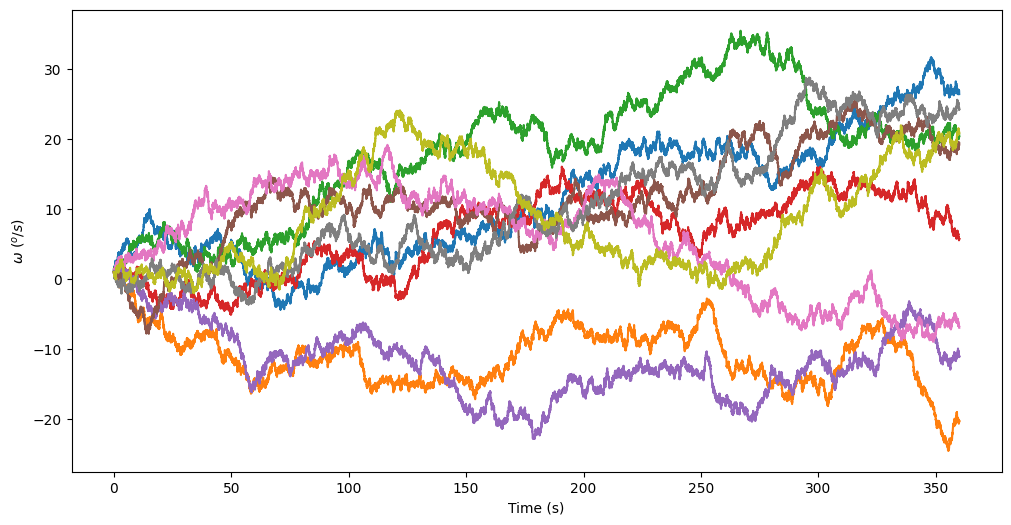

In [5]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6])
    plt.plot(time, meas_hist[:,j*6+1])
    plt.plot(time, meas_hist[:,j*6+2])
plt.ylabel("$\omega$ ($^o/s$)")
plt.xlabel("Time (s)")

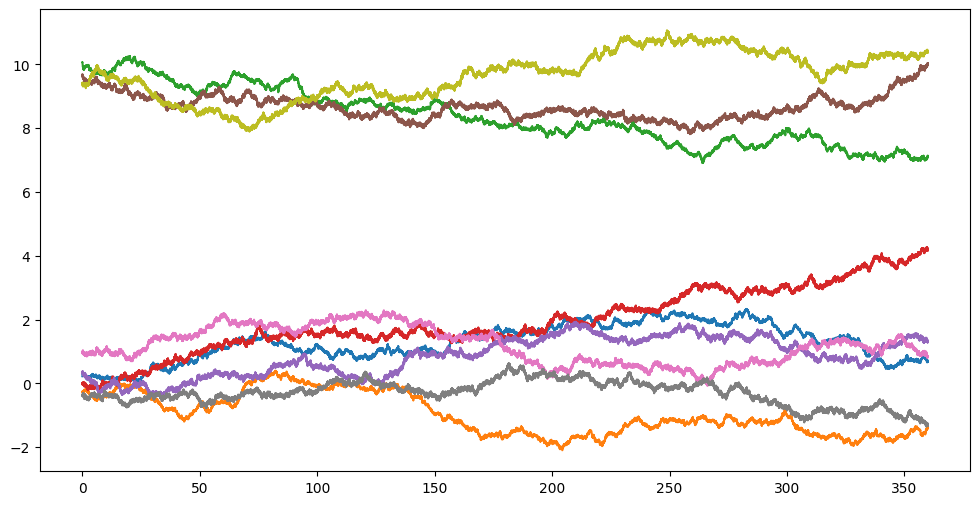

In [6]:
plt.figure(figsize = (12, 6))
for j in range(num_imus):
    plt.plot(time, meas_hist[:,j*6+3])
    plt.plot(time, meas_hist[:,j*6+4])
    plt.plot(time, meas_hist[:,j*6+5])